In [1]:

import importlib
import experiment
importlib.reload(experiment)
import models
importlib.reload(models)
from experiment import *

In [2]:
exp_name = "protA-d1-FL_e3-fl"

from pathlib import Path
path = Path("./data/protA_DCP1-FL_EDC3-FL/protA_Dcp1_Edc3_final")
fs = sorted(list(path.glob("*.csv")))

controls_path = Path("./data/protA_DCP1-FL_EDC3-FL/protA_Dcp1_Edc3_final_refs")
controls_fs = sorted(list(controls_path.glob("*.csv")))
print(len(fs))
print(len(controls_fs))

12
6


In [3]:
concs = {5 : 25,
12 : 25,
7 : 50,
6 : 50,
1 : 100,
2 : 100,
9 : 200,
8 : 200,
4 : 400,
13 : 400,
10 : 800,
3 : 800}

In [4]:
exp = Exp()
exp.load_bli_data(fs)
for c, ds in zip(concs, exp):
    idx = int(ds.name[-7:-4])
    ds.steps[0].concentration = concs[idx] * 1e-9

#remove loading and baselines because you forgot to do that in exp class 
for ds in exp:
    s = ds.steps[0].start
    mask = ds.t >= s
    ds.response = ds.response[mask]
    ds.t = ds.t[mask]

# exp.crop(2)

exp.interstep_correction()

#correct vs min
for ds in exp:
    min_val = ds.response.min()
    ds.response = ds.response - min_val


In [5]:
# #assign conentrations to controls
# controls_c = [0.,0.2,0.4,0.8,1.6]
# controls_c = [c*1e-6 for c in controls_c]

# for ds, c in zip(controls, controls_c):
#     ds.steps[0].concentration = c




In [6]:
# controls_dict = {}
# for ds in controls:
#     control_mask = ds.t>=ds.steps[0].start
#     c = ds.steps[0].concentration
#     controls_dict[c] = ds.response[control_mask]

# #subtract controls from ds
# for ds in exp:
#     if not ds.use_for_fit: continue
#     print(ds.steps[0].concentration)
#     start = ds.steps[0].start
#     mask = ds.t>=start
#     r = ds.response[mask]
#     c = ds.steps[0].concentration
#     if c in controls_dict:
#         print('correcting c=',c)
#         ds.response[mask] = np.subtract(r, controls_dict[c])
        

# exp.plot()

Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <Axes: >)

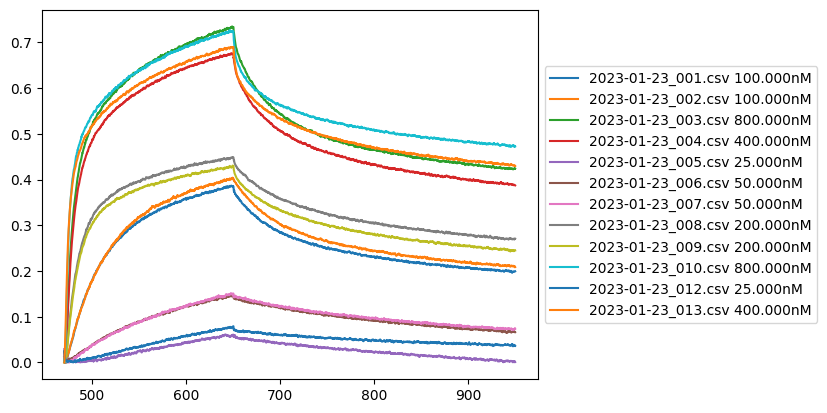

In [7]:
#remove some datasets
ds_to_remove = []
for ds in exp:
    if ds.steps[0].concentration == 801*1e-9:
        ds_to_remove.append(ds)
    else:
        ds.use_for_fit = True
for ds in ds_to_remove:
    exp.datasets.remove(ds)

exp.plot()

In [8]:
exp.model = models.Bivalent_analyte()
exp.model.params_definitions

{'ka1': <Parameter 'ka1', value=10000.0, bounds=[10.0:100000000.0]>,
 'kd1': <Parameter 'kd1', value=0.01, bounds=[1e-06:0.1]>,
 'ka2': <Parameter 'ka2', value=0.01, bounds=[1e-07:10000000.0]>,
 'kd2': <Parameter 'kd2', value=0.01, bounds=[1e-07:10000000.0]>,
 'kt': <Parameter 'kt', value=10000000.0, bounds=[10.0:1000000000000.0]>,
 'ymax': <Parameter 'ymax', value=1, bounds=[0:1000]>,
 'offset': <Parameter 'offset', value=0, bounds=[-10:10]>}

In [9]:
# exp.model.params_definitions['ymax'].user_data['type']='global'

# exp.model.params_definitions['ymax1'].max=2
# exp.model.params_definitions['ymax2'].max=2
# exp.model.params_definitions['kd1'].min=1e-12
# exp.model.params_definitions['kd2'].min=1e-12

# exp.model.params_definitions['ymax2'].user_data['type']='global'
# exp.model.params_definitions['ymax3'].user_data['type']='global'
 

exp.create_params(offsets=0, mtl = 0, define_ymax = 'local_dataset')
exp.params


name,value,initial value,min,max,vary
ka1,10000.0000,10000.0,10.0000000,1.0000e+08,True
kd1,0.01000000,0.01,1.0000e-06,0.10000000,True
ka2,0.01000000,0.01,1.0000e-07,10000000.0,True
kd2,0.01000000,0.01,1.0000e-07,10000000.0,True
ymax_ds0,1.00000000,1,0.00000000,1000.00000,True
ymax_ds1,1.00000000,1,0.00000000,1000.00000,True
ymax_ds2,1.00000000,1,0.00000000,1000.00000,True
ymax_ds3,1.00000000,1,0.00000000,1000.00000,True
ymax_ds4,1.00000000,1,0.00000000,1000.00000,True
ymax_ds5,1.00000000,1,0.00000000,1000.00000,True


In [10]:
exp.fit_params()

fitting using: least_squares


'`xtol` termination condition is satisfied.'

(<Figure size 640x480 with 1 Axes>, <Axes: >)

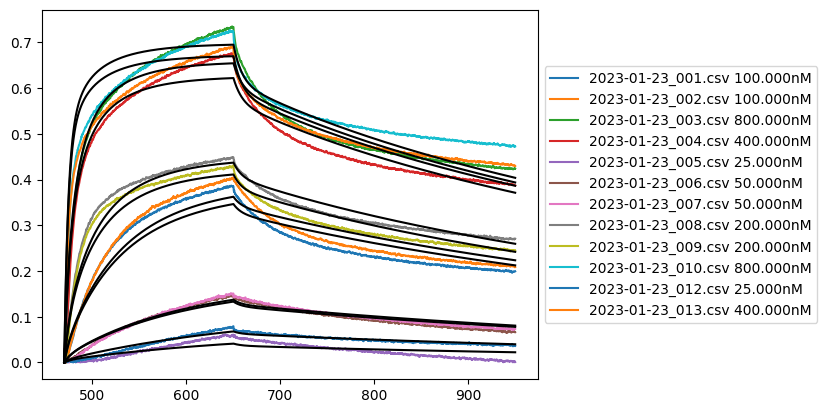

In [11]:
flag = False
for par in exp.params:
    if "offset" in par:
        flag=True

exp.plot(fit=True, correct_offsets=flag)

In [12]:
exp.model.name

'Bivalent analyte'

In [13]:
exp.result

In [26]:
import plotly.graph_objects as go

fig = go.Figure()

for ds in exp.datasets:
    if ds.use_for_fit == False: continue
    x = np.array([])
    y = np.array([])
    y_fit = np.array([])
    
    for step in ds.steps:
        # if step.concentration>0: color = 'orangered'
        # elif step.concentration==0: color = 'cornflowerBlue'
        # else: color = 'lightgrey'
        mask = (ds.t>=step.start) & (ds.t<step.stop)

        if f"offset_ds{ds.index}_step{step.index}" in exp.params:
                offset = exp.params[f'offset_ds{ds.index}_step{step.index}'].value
        else: 
            offset = 0

        
        x_step = ds.t[mask]
        y_step = ds.response[mask] - offset
        y_fit_step = ds.fit_response[mask] - offset

        x = np.concatenate([x, x_step])
        y = np.concatenate([y, y_step])
        y_fit = np.concatenate([y_fit, y_fit_step])

    
    x = x - x[0]
    fig.add_scatter(x = x, 
                    y = y_fit,
                    marker=dict(size=0, 
                            color='black',
                            line=dict(width=1, color='black')),
                    line=dict(
                         width=2, 
                         color='black'
                         ),
                    name=ds.steps[0].concentration,)

        

    fig.add_scatter(x = x,
                    y = y,
                    marker=dict(
                            size=0, 
                            #color=color, 
                            line=dict(
                                    width=0.1, 
                                    #color=color
                                    )),
                    line=dict(
                            width=1, 
                            #color=color
                            ),
                    name=f"{ds.index}_{ds.steps[0].concentration:.2e}",
                    )



fig.update_layout(
            height=600,
            width = 800,
            font_family="Arial",
            font_size = 24,
            showlegend=False,
            margin=dict(l=0,r=0,b=0,t=0,pad=0), 
            template='plotly_white',
            paper_bgcolor="rgb(255, 255, 255)",  
            plot_bgcolor="rgb(255, 255, 255)") 

fig.update_xaxes(
    ticklabelposition="inside top", 
    title='czas [s]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)

fig.update_yaxes(
    ticklabelposition="outside top", 
    title='sygnał [nm]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)



fig.show()

In [15]:
exp.model.name

'Bivalent analyte'

In [25]:
for ds in exp:
    if ds.index in [11, 9, 5, 1, 8, 4]:
        ds.use_for_fit = False
    if ds.index in []:
        ds.use_for_fit = True
    # if ds.steps[0].concentration==16e-6:
    #     ds.use_for_fit = True
[ds.index for ds in exp]



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [17]:
for ds in exp:
    ds.use_for_fit = True

In [18]:
exp.crop(1)


In [19]:
exp.model.name

'Bivalent analyte'

In [20]:
import kaleido
fig.write_image(f'{exp_name}-{exp.model.name}.png')

In [27]:
from lmfit.printfuncs import fitreport_html_table
s = fitreport_html_table(exp.result, show_correl=True,  min_correl=0.1)

with open(f"{exp_name}-{exp.model.name}.htm", 'w') as f: 
    f.write(s)


In [24]:
####### R2
params = exp.params
y = np.concatenate([dataset.response for dataset in exp.datasets]).flatten()
y = y[~np.isnan(y)]
y = np.var(y, ddof=2)
1 - exp.result.redchi / y

0.985997811315724

In [434]:
0.04410855 	 / 		94559.1265


4.6646528614030716e-07

In [435]:
8.2533e-04 / 		0.05528018 

0.014929944149964779

In [433]:
	0.02925087 / 15761.3551

1.8558600966994266e-06

In [135]:
exp.model.name

'Heterogeneous ligand'

In [28]:
exp.result